# Library / Packages

In [1]:
# basic library
import os
import pandas as pd
import numpy as np
import sys


# complex math
from scipy import stats
from scipy.stats import gaussian_kde

# data preparation
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer 

# data blueprint
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, NearMiss
from imblearn.combine import SMOTETomek
from sklearn.neighbors import NearestNeighbors

# data modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

# data cross-validation
from sklearn.model_selection import cross_val_score, StratifiedKFold

# data metrics
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix

# data tuning   
from itertools import product
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.calibration import CalibratedClassifierCV

# visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# pickle and .env
from dotenv import dotenv_values
import pickle

# Format

In [2]:
def lab_round(x, pos): 
    if abs(x) >= 1e9: 
        return f'{x/1e9} B'
    
    elif abs(x) >= 1e6:
        return f'{x/1e6} M'
    
    elif abs(x) >= 1e3:
        return f'{x/1e3} K'
    
    else:
        return f'{x}'
    
def val_round(x):
    if abs(x) >= 1e9:
        return f'{x/1e9:.2f} B'
    
    elif abs(x) >= 1e6:
        return f'{x/1e6:.2f} M'
    
    elif abs(x) >= 1e3:
        return f'{x/1e3:.2f} K'
    
    else:
        return f'{x:.2f}'

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# Fungsi untuk konversi tipe data
def convert_object_columns_to_numeric(df):
    for col in df.select_dtypes(include = ['object']).columns:  
        try:
            # Cek apakah semua nilai bisa dikonversi ke float
            df[col] = pd.to_numeric(df[col], errors='raise')
            
            # Jika bisa, ubah ke int jika semua nilai adalah bilangan bulat
            if all(df[col] % 1 == 0):  # Cek apakah semua nilai adalah bilangan bulat
                df[col] = df[col].astype(int)

        except ValueError:
            pass  # Jika ada nilai non-angka, biarkan tetap object
        
    return df

# Data Source

In [5]:
# parameter
share = {**dotenv_values('../.env.shared')} 

# read pickle
with open(share['MODEL_DATA'], 'rb') as f:
    loaded_data = pickle.load(f)

cc_df = pd.DataFrame(loaded_data)
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   credit_card                294588 non-null  int64         
 1   datetime                   294588 non-null  datetime64[ns]
 2   long                       294588 non-null  float64       
 3   lat                        294588 non-null  float64       
 4   zipcode                    294588 non-null  int64         
 5   state                      294588 non-null  object        
 6   city                       294588 non-null  object        
 7   date                       294588 non-null  object        
 8   year                       294588 non-null  int32         
 9   quarter                    294588 non-null  object        
 10  month                      294588 non-null  object        
 11  season                     294588 non-null  object  

In [6]:
cc_df.head()

,credit_card,datetime,long,lat,zipcode,state,city,date,year,quarter,month,season,week_cat,day,time,limit_cat,prev_time,geo_cat,fraud,time_diff_hour,transaction_dollar_amount,speed_km/h,distance_km,cc_id,trx_id
0,9484591448272784,2015-07-31 09:39:48,-90.045639,29.889039,70112,la,new orleans,2015-07-31,2015,2015Q3,july,summer,weekday,friday,09:39:48,very_low,2015-10-27 20:34:03,normal,not_fraud,2.005466,-1.093130,0.007087,0.581068,1907e66fb4a1471e8eca4c9a8aa917e99585681548cf37...,9fba7100ae8d08177a1badff3adab0335a5b88bdce0e4d...
1,7053196367895112,2015-07-31 11:03:48,-74.027561,40.689615,10001,ny,new york,2015-07-31,2015,2015Q3,july,summer,weekday,friday,11:03:48,low,2015-08-29 17:05:27,normal,not_fraud,0.179885,-1.446862,0.261184,0.827346,ca6afc24733d28aeda6c4d666ce2f56752a1179a7e776e...,74a853d1125b167a6b2d5df0acc3f62c2c565e01caa60e...
2,9528285469413252,2015-07-31 11:10:14,-72.139485,43.108100,3280,nh,washington,2015-07-31,2015,2015Q3,july,summer,weekday,friday,11:10:14,very_high,2015-10-14 19:06:04,normal,not_fraud,1.673976,0.358233,0.007087,0.329780,1824df93a6b8a5382521f23b0f2f6bbf8d5a07716854e6...,751d3b3e065c22600e5d524d554b0196f9984e35a861b0...
3,1845720274833905,2015-07-31 11:28:55,-89.002148,40.804323,61738,il,el paso,2015-07-31,2015,2015Q3,july,summer,weekday,friday,11:28:55,medium,2015-08-29 19:33:54,normal,not_fraud,0.183490,0.305698,0.007087,0.347209,e67f74716090388cb093d22666ffc74a8bbe6809edf92d...,d25714446e71d4046fc6b5bdc80444b9af80750fef5bc6...
4,7850942767136368,2015-07-31 11:38:51,-72.025675,43.210753,3280,nh,washington,2015-07-31,2015,2015Q3,july,summer,weekday,friday,11:38:51,very_low,2015-08-21 03:39:50,normal,not_fraud,-0.213998,-0.010331,0.261184,0.170737,18bfead1b1dd6e4d1f6bed41ffea23be816e17478de1a5...,677ca02dfab0bbdef0d0137feefaf565caba030e828376...


## Data Distribution

In [7]:
rows = cc_df.shape[0]
cols = cc_df.shape[1]

if rows <= 5000 or cols <= 20:
    category = "Small Dataset"

elif rows <= 50000 and cols <= 100:
    category = "Medium Dataset"

elif rows <= 1000000 and cols <= 500:
    category = "Large Dataset"

elif rows <= 10000000 and cols <= 1000:
    category = "Very Large Dataset"

else:
    category = "Massive Dataset"

print(f'Rows: {val_round(rows)}, Columns: {val_round(cols)}, then Dataset Category: {category.upper()}!!!')

Rows: 294.59 K, Columns: 25.00, then Dataset Category: LARGE DATASET!!!


## Check Imbalanced Data

### Proportion

In [8]:
# Check proportion
print(f'{cc_df["fraud"].value_counts()} \n')
print(round(cc_df["fraud"].value_counts(normalize = True) * 100, 2))

fraud
not_fraud    282742
fraud         11846
Name: count, dtype: int64 

fraud
not_fraud    95.98
fraud         4.02
Name: proportion, dtype: float64


### Imbalance Ratio

In [9]:
# 
minority_class = cc_df["fraud"].value_counts().min()
majority_class = cc_df["fraud"].value_counts().max()

# 
imbalance_ratio = majority_class / minority_class
print(f"Imbalance Ratio (IR): {imbalance_ratio:.2f}")

Imbalance Ratio (IR): 23.87


### Check Irrelevant Data

#### Threshold Methode 

In [10]:
from sklearn.feature_selection import VarianceThreshold

# Drop kolom non-numerik
df_numeric = cc_df.select_dtypes(include = ['number'])
print(f'numeric columns: {df_numeric.columns}\n')

# Inisialisasi VarianceThreshold (misalnya, ambang batas 0.01)
selector = VarianceThreshold(threshold = 0.01)
df_var_selected = selector.fit_transform(df_numeric)

# Fitur yang dipertahankan
selected_features = df_numeric.columns[selector.get_support()]
print("Fitur yang dipertahankan:", selected_features)

numeric columns: Index(['credit_card', 'long', 'lat', 'zipcode', 'year', 'time_diff_hour',
       'transaction_dollar_amount', 'speed_km/h', 'distance_km'],
      dtype='object')

Fitur yang dipertahankan: Index(['credit_card', 'long', 'lat', 'zipcode', 'time_diff_hour',
       'transaction_dollar_amount', 'speed_km/h', 'distance_km'],
      dtype='object')


In [11]:
# Seleceted numeric columns
filter_numeric = ['long', 'lat', 'credit_card', 'zipcode']
selected_numeric = selected_features.drop(filter_numeric)

#
print("Numeric column untuk modeling:", selected_numeric)

Numeric column untuk modeling: Index(['time_diff_hour', 'transaction_dollar_amount', 'speed_km/h',
       'distance_km'],
      dtype='object')


#### Relevant Column

In [12]:
# Check Column Category
check_cat = cc_df.select_dtypes(include = ['object'])

for i in check_cat.columns:
    unique_values = check_cat[i].unique()  # Mendapatkan nilai unik
    unique_count = check_cat[i].nunique()  # Menghitung jumlah unik
    print(f'{i.upper()} \t: {unique_values}')
    print(f'{"-" * 50} \n')

STATE 	: ['la' 'ny' 'nh' 'il' 'pa' 'nj' 'mo' 'md' 'ca' 'tx' 'me' 'vt' 'al' 'wv'
 'pr' 'wa' 'nc' 'ga' 'ma' 'ok' 'mi' 'ut' 'fl' 'hi' 'ia' 'nm' 'oh' 'az'
 'va' 'in' 'ri' 'id' 'co' 'ct' 'ks']
-------------------------------------------------- 

CITY 	: ['new orleans' 'new york' 'washington' 'el paso' 'dallas' 'houston'
 'birmingham' 'kansas city' 'austin' 'pasadena' 'los angeles' 'fort worth'
 'jackson' 'pittsburgh' 'portland' 'albany' 'charlotte' 'huntsville'
 'madison' 'orlando' 'san antonio' 'seattle' 'minneapolis' 'sacramento'
 'san francisco' 'memphis' 'dayton' 'denver' 'milwaukee' 'omaha' 'trenton'
 'springfield' 'phoenix' 'oklahoma city' 'charleston' 'miami' 'long beach'
 'quitman' 'saint louis' 'friendship' 'chicago' 'salt lake city'
 'richmond' 'pensacola' 'san diego' 'atlanta' 'honolulu' 'greensboro'
 'newark' 'rochester' 'lafayette' 'columbus' 'staten island' 'des moines'
 'las vegas' 'chester' 'cincinnati' 'hillsboro' 'tucson' 'buffalo'
 'arlington' 'shreveport' 'philadelphia' 

In [13]:
for i in check_cat.columns:
    unique_count = check_cat[i].nunique()  # Menghitung jumlah nilai unik
    
    if unique_count > 10:  # Filter hanya kolom dengan nilai unik lebih dari 10
        unique_values = check_cat[i].unique()  # Mendapatkan nilai unik
        # print(f'{i.upper()} \t: {unique_values}')
        print(f'Jumlah unik {i.upper()} \t: {unique_count}')
        print(f'{"-" * 50} \n')


Jumlah unik STATE 	: 35
-------------------------------------------------- 

Jumlah unik CITY 	: 124
-------------------------------------------------- 

Jumlah unik DATE 	: 92
-------------------------------------------------- 

Jumlah unik TIME 	: 51419
-------------------------------------------------- 

Jumlah unik CC_ID 	: 294588
-------------------------------------------------- 

Jumlah unik TRX_ID 	: 294588
-------------------------------------------------- 



In [14]:
# Drop kolom numerik
df_obj = cc_df.select_dtypes(include = ['object'])
print(f'objetc columns: {df_obj.columns}\n')

objetc columns: Index(['state', 'city', 'date', 'quarter', 'month', 'season', 'week_cat',
       'day', 'time', 'limit_cat', 'geo_cat', 'fraud', 'cc_id', 'trx_id'],
      dtype='object')



In [15]:
# selected object columns
filter_obj = ['city', 'limit_cat', 'fraud', 'geo_cat']
selected_object = df_obj[filter_obj].columns

#
print("Object column untuk modeling:", selected_object)

Object column untuk modeling: Index(['city', 'limit_cat', 'fraud', 'geo_cat'], dtype='object')


In [16]:
# 
trans_col = selected_numeric.append(selected_object)

# 
trans_col = cc_df[trans_col]
trans_col.head()

,time_diff_hour,transaction_dollar_amount,speed_km/h,distance_km,city,limit_cat,fraud,geo_cat
0,2.005466,-1.093130,0.007087,0.581068,new orleans,very_low,not_fraud,normal
1,0.179885,-1.446862,0.261184,0.827346,new york,low,not_fraud,normal
2,1.673976,0.358233,0.007087,0.329780,washington,very_high,not_fraud,normal
3,0.183490,0.305698,0.007087,0.347209,el paso,medium,not_fraud,normal
4,-0.213998,-0.010331,0.261184,0.170737,washington,very_low,not_fraud,normal


### Check Noise Data

#### Boxplot

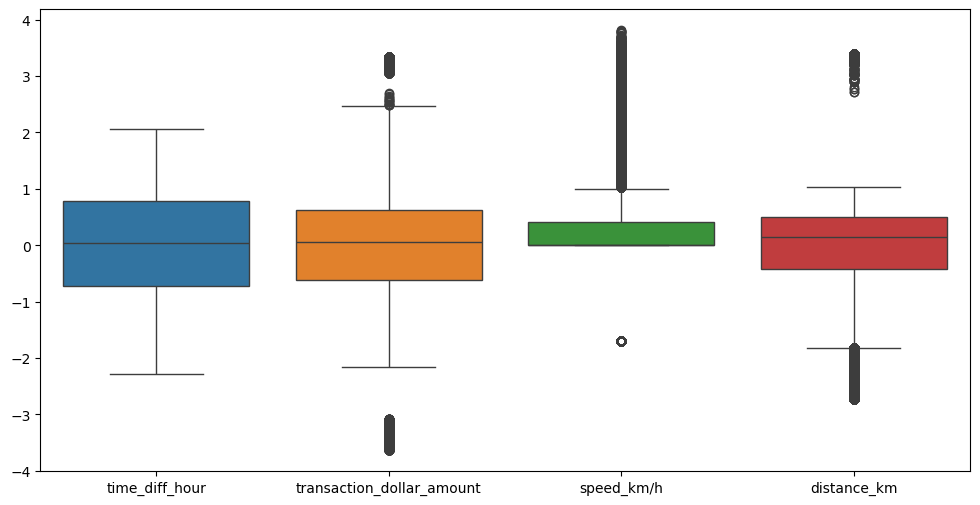

In [17]:
plt.figure(figsize = (12,6))
sns.boxplot(data = trans_col.select_dtypes(include = ["number"])) 
plt.show()

#### Z-Score

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Kolom numerik yang ingin dicek outliernya
num_cols = ["transaction_dollar_amount", "distance_km", 'speed_km/h']

# Hitung z-score
z_scores = np.abs(zscore(trans_col[num_cols]))

# Tandai data yang memiliki outlier
outlier_mask = (z_scores > 3).any(axis=1)

# Jumlah outlier sebelum Winsorization
num_outliers_before = outlier_mask.sum()
print(f"Jumlah outlier yang terdeteksi: {num_outliers_before} \n")

Jumlah outlier yang terdeteksi: 17391 



#### Winsorization

In [19]:
clip_percent = 2.4

# Winsorization hanya untuk data "not_fraud"
for col in num_cols:
    lower = np.percentile(trans_col[trans_col["fraud"] == "not_fraud"][col], clip_percent)
    upper = np.percentile(trans_col[trans_col["fraud"] == "not_fraud"][col], 100 - clip_percent)

    trans_col.loc[trans_col["fraud"] == "not_fraud", col] = np.clip(
        trans_col.loc[trans_col["fraud"] == "not_fraud", col], lower, upper
    )

# Cek apakah outlier masih ada setelah Winsorization
z_scores_after = np.abs(zscore(trans_col[num_cols]))
outlier_mask_after = (z_scores_after > 3).any(axis=1)

num_outliers_after = outlier_mask_after.sum()
print(f"Jumlah outlier setelah Winsorization: {num_outliers_after} \n")

Jumlah outlier setelah Winsorization: 8192 



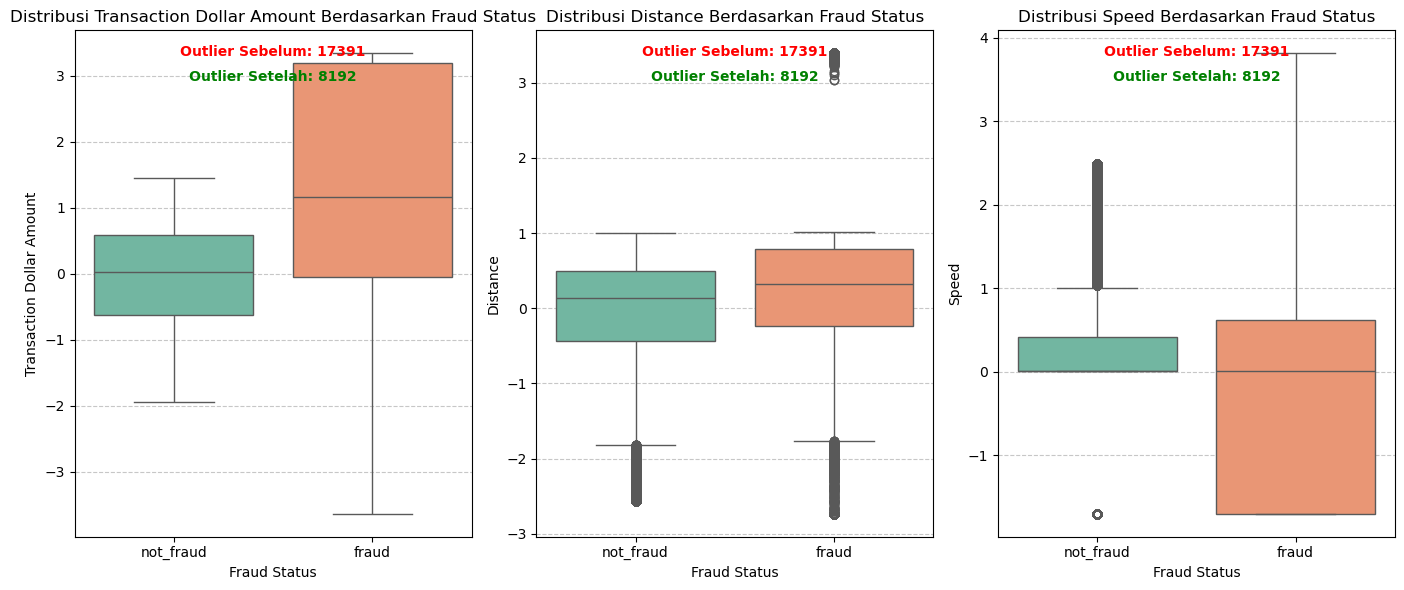

In [20]:
# Visualisasi dengan subplot
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# Boxplot untuk transaction_dollar_amount
sns.boxplot(x = "fraud", y = "transaction_dollar_amount", hue = "fraud", 
            data = trans_col, ax = axes[0], palette = "Set2", legend = False)

axes[0].set_title("Distribusi Transaction Dollar Amount Berdasarkan Fraud Status")
axes[0].set_ylabel("Transaction Dollar Amount")
axes[0].set_xlabel("Fraud Status")
axes[0].grid(axis = "y", linestyle = "--", alpha = 0.7)

# Boxplot untuk distance
sns.boxplot(x = "fraud", y = "distance_km", hue = "fraud", 
            data = trans_col, ax = axes[1], palette = "Set2", legend = False)

axes[1].set_title("Distribusi Distance Berdasarkan Fraud Status")
axes[1].set_ylabel("Distance")
axes[1].set_xlabel("Fraud Status")
axes[1].grid(axis = "y", linestyle = "--", alpha = 0.7)

# Boxplot untuk speed_km/h
sns.boxplot(x = "fraud", y = "speed_km/h", hue = "fraud", 
            data = trans_col, ax = axes[2], palette = "Set2", legend = False)

axes[2].set_title("Distribusi Speed Berdasarkan Fraud Status")
axes[2].set_ylabel("Speed")
axes[2].set_xlabel("Fraud Status")
axes[2].grid(axis = "y", linestyle = "--", alpha = 0.7)

# Tambahkan anotasi jumlah outlier
for ax in axes:
    ax.annotate(f"Outlier Sebelum: {num_outliers_before}", xy = (0.5, 0.95), xycoords = "axes fraction", 
                ha = "center", fontsize = 10, color = "red", fontweight = "bold")
    
    ax.annotate(f"Outlier Setelah: {num_outliers_after}", xy = (0.5, 0.90), xycoords = "axes fraction", 
                ha = "center", fontsize = 10, color = "green", fontweight = "bold")

plt.tight_layout()
plt.show()

# Data Transformation

In [21]:
# Ensure Data Consistency (before after same after winsorization)
print("Proporsi Label Setelah Preprocessing: ")
print("=" * 50)

print(trans_col["fraud"].value_counts(normalize = True) * 100, '\n')
print(trans_col["fraud"].value_counts())

Proporsi Label Setelah Preprocessing: 
fraud
not_fraud    95.978791
fraud         4.021209
Name: proportion, dtype: float64 

fraud
not_fraud    282742
fraud         11846
Name: count, dtype: int64


In [22]:
# 
minority_class = cc_df["fraud"].value_counts().min()
majority_class = cc_df["fraud"].value_counts().max()

# 
imbalance_ratio = majority_class / minority_class
print(f"Imbalance Ratio (IR): {imbalance_ratio:.2f}")

Imbalance Ratio (IR): 23.87


In [23]:
# remove NaN from target
trans_df = trans_col.dropna(subset = ['fraud'])

# check value
print(round(trans_df["fraud"].value_counts(normalize = True) * 100, 2), "\n")
print(trans_df["fraud"].value_counts())

fraud
not_fraud    95.98
fraud         4.02
Name: proportion, dtype: float64 

fraud
not_fraud    282742
fraud         11846
Name: count, dtype: int64


## Split Data

In [24]:
from sklearn.model_selection import train_test_split

# split data
X = trans_df.drop(columns = ["fraud"]).copy()
y = trans_df["fraud"].copy()

# 
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 7 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   time_diff_hour             294588 non-null  float64
 1   transaction_dollar_amount  294588 non-null  float64
 2   speed_km/h                 294588 non-null  float64
 3   distance_km                294588 non-null  float64
 4   city                       294588 non-null  object 
 5   limit_cat                  294588 non-null  object 
 6   geo_cat                    294588 non-null  object 
dtypes: float64(4), object(3)
memory usage: 15.7+ MB


In [25]:
# Split data sebelum preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

# Konversi target ke numeric (setelah split)
y_train = y_train.map({"not_fraud": 0, "fraud": 1})
y_test = y_test.map({"not_fraud": 0, "fraud": 1})

# Menampilkan informasi dataset
print("=" * 50)
print("Data has been split!!! \n")
print(f"Train set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print("=" * 50)

Data has been split!!! 

Train set size: 206211
Test set size: 88377


### Grouping Category

In [26]:
# Daftar kolom untuk label encoding (kolom ordinal)
ordinal_set = {'limit_cat'}

# Inisialisasi list untuk menyimpan kolom yang telah dikelompokkan
ordinal_cols, ohe_cols, label_cols, numeric_cols = [], [], [], []

for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:
        numeric_cols.append(col)

    elif X[col].dtype == 'object' or X[col].dtype.name == "category":
        unique_count = X[col].nunique()  # Menghitung jumlah unik
        
        if col in ordinal_set:
            ordinal_cols.append(col)
            
        elif unique_count > 10:  # Jika nilai unik lebih dari 10 → label encoding
            label_cols.append(col)
            
        else:  # Jika nilai unik <= 10 → one-hot encoding
            ohe_cols.append(col)

# Menampilkan hasil
print("Ordinal Columns: \t", ordinal_cols)
print("One-Hot Columns: \t", ohe_cols)
print("Label Columns: \t\t", label_cols)
print("Numeric Columns: \t", numeric_cols)

Ordinal Columns: 	 ['limit_cat']
One-Hot Columns: 	 ['geo_cat']
Label Columns: 		 ['city']
Numeric Columns: 	 ['time_diff_hour', 'transaction_dollar_amount', 'speed_km/h', 'distance_km']


In [27]:
# Check Ordinal Columns
for i in ordinal_cols:
    print(f'{i.upper()} \t: {check_cat[i].unique()}')
    print(f'{"-" * 50}')

LIMIT_CAT 	: ['very_low' 'low' 'very_high' 'medium' 'high']
--------------------------------------------------


In [28]:
# Menentukan urutan kategori masing-masing kolom
oridnal_cat = [
    ["very_low", "low", "medium", "high", "very_high"],   # Urutan untuk limit_cat
]

### Transform Parameter

In [29]:
# Transformasi
numerical_tf = RobustScaler(
    with_centering = True,          # Jika True, akan mengurangi median sebelum scaling 
    with_scaling = True,            # Jika True, akan membagi dengan IQR 
    quantile_range = (25.0, 75.0),  # Rentang persentil untuk IQR (default: Q1=25%, Q3=75%) 
    unit_variance = False,          # Jika True, akan menyesuaikan data agar memiliki varians sekitar 1 
    copy = False                    # Jika False, transformasi dilakukan in-place pada array input 
    )

ohe_tf = OneHotEncoder(
    handle_unknown = 'ignore', 
    sparse_output = True, 
    max_categories = 50
    )

ordinal_tf = OrdinalEncoder(
    categories = oridnal_cat, 
    handle_unknown = 'use_encoded_value', 
    unknown_value = -1
    )

# Fungsi untuk Label Encoding
def label_encode_columns(X):
    X = X.copy()  # Hindari mengubah DataFrame asli
    for col in label_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        
    return X

In [30]:
# Column Transformer dengan FunctionTransformer
prep_stage_2 = ColumnTransformer(
    transformers = [
        ("num", numerical_tf, numeric_cols),  # Standarisasi numerik
        ("ohe", ohe_tf, ohe_cols), 
        ("label", FunctionTransformer(label_encode_columns, validate = False), label_cols),  # Label encoder in pipeline
        ("ord", ordinal_tf, ordinal_cols)
    ], remainder = "passthrough")

In [31]:
X_train_tf = prep_stage_2.fit_transform(X_train)  # Fit & Transform Training Data
X_test_tf = prep_stage_2.transform(X_test)  # Transform Test Data

In [32]:
# get feature names after pipeline
num_features = numeric_cols 
cat_features = prep_stage_2.named_transformers_["ohe"].get_feature_names_out(ohe_cols) 
ord_features = ordinal_cols 
label_features = label_cols 

# combine column
transformed_columns = (list(num_features) + 
                       list(cat_features) + 
                       list(ord_features) + 
                       list(label_features)) 

# Dataframe after transform
df_X_train_tf = pd.DataFrame(X_train_tf, columns = transformed_columns)
print(f'Total rows X_train Transformed: {df_X_train_tf.shape} \n')

df_X_test_tf = pd.DataFrame(X_test_tf, columns = transformed_columns)
print(f'Total rows X_test Transformed: {df_X_test_tf.shape}')

Total rows X_train Transformed: (206211, 8) 

Total rows X_test Transformed: (88377, 8)


## Re-Sampling

In [33]:
# Check Target Proportion
print("Check Data:")
print(f"{y_train.value_counts(normalize = True) * 100} \n")
print(y_train.value_counts())

Check Data:
fraud
0    95.978876
1     4.021124
Name: proportion, dtype: float64 

fraud
0    197919
1      8292
Name: count, dtype: int64


In [34]:
# from imblearn.under_sampling import RandomUnderSampler, TomekLinks
# from collections import Counter

# # Cek distribusi awal
# print(f"Distribusi kelas sebelum balancing \t\t: {Counter(y_train)}")

# # 🔹 Langkah 1: Random Undersampling untuk mengurangi kelas mayoritas
# rus = RandomUnderSampler(sampling_strategy = 0.5, random_state = 42)  # Minoritas menjadi 50% dari mayoritas
# X_rus, y_rus = rus.fit_resample(X_train_tf, y_train)
# print(f"Distribusi kelas setelah Random Undersampling \t: {Counter(y_rus)}")

# # 🔹 Langkah 2: Tomek Links untuk membersihkan batas kelas
# tl = TomekLinks()
# X_train_resample, y_train_resample = tl.fit_resample(X_rus, y_rus)
# print(f"Distribusi kelas setelah Tomek Links \t\t: {Counter(y_train_resample)}")

In [35]:
# from imblearn.combine import SMOTEENN
# from collections import Counter

# # Cek distribusi awal
# print(f"Distribusi sebelum balancing \t\t: {Counter(y_train)}")

# smote_enn = SMOTEENN(random_state=42)
# X_train_resample, y_train_resample = smote_enn.fit_resample(X_train_tf, y_train)


# print(f"Distribusi setelah balancing \t\t: {Counter(y_train_resample)}")

In [36]:
from imblearn.combine import SMOTETomek
from collections import Counter

# Cek distribusi awal
print(f"Distribusi sebelum balancing \t\t: {Counter(y_train)}")

smotetomek = SMOTETomek(random_state=42)
X_train_resample, y_train_resample = smotetomek.fit_resample(X_train_tf, y_train)


print(f"Distribusi setelah balancing \t\t: {Counter(y_train_resample)}")

Distribusi sebelum balancing 		: Counter({0: 197919, 1: 8292})
Distribusi setelah balancing 		: Counter({0: 197919, 1: 197919})


In [37]:
# Train Resampling
print("After Resampling:")
print(f"{y_train_resample.value_counts(normalize = True) * 100} \n")
print(y_train_resample.value_counts())

After Resampling:
fraud
0    50.0
1    50.0
Name: proportion, dtype: float64 

fraud
0    197919
1    197919
Name: count, dtype: int64


In [38]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Hitung class weight secara manual
class_weights = compute_class_weight(class_weight = "balanced", classes = np.array([0, 1]), y = y_train_resample)

print(f"Bobot kelas 0 (Not Fraud): {class_weights[0]:.2f}")
print(f"Bobot kelas 1 (Fraud): {class_weights[1]:.2f}")

Bobot kelas 0 (Not Fraud): 1.00
Bobot kelas 1 (Fraud): 1.00


### Leak Checking

#### Train Data

In [39]:
# Konversi X_train_resample ke DataFrame dengan nama kolom yang sama seperti sebelum resampling
X_train_leak = pd.DataFrame(X_train_resample, columns = df_X_train_tf.columns)

# Cek korelasi antara fitur dan label
print(X_train_leak.corrwith(pd.Series(y_train_resample)))

time_diff_hour              -0.459917
transaction_dollar_amount    0.483396
speed_km/h                  -0.032129
distance_km                  0.298506
geo_cat_anomaly              0.586312
geo_cat_normal              -0.586312
limit_cat                   -0.017156
city                        -0.005987
dtype: float64


In [40]:
from sklearn.feature_selection import mutual_info_classif

train_mi_scores = mutual_info_classif(X_train_leak, y_train_resample, discrete_features = 'auto')
train_mi_scores = pd.Series(train_mi_scores, index = X_train_leak.columns).sort_values(ascending = False)

print("Mutual Information Scores:\n", train_mi_scores.head(20))  # Tampilkan 20 fitur paling informatif


Mutual Information Scores:
 transaction_dollar_amount    0.462912
time_diff_hour               0.262908
geo_cat_normal               0.250406
speed_km/h                   0.232937
geo_cat_anomaly              0.223244
distance_km                  0.108224
limit_cat                    0.063095
city                         0.062157
dtype: float64


In [41]:
# Check High Correlations
correlation_values = X_train_leak.corrwith(pd.Series(y_train_resample))
high_correlation_features = correlation_values[correlation_values.abs() > 0.9]

print(high_correlation_features)

Series([], dtype: float64)


In [42]:
X_train_leak = X_train_leak.drop(columns = high_correlation_features.index)
X_train_leak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395838 entries, 0 to 395837
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   time_diff_hour             395838 non-null  float64
 1   transaction_dollar_amount  395838 non-null  float64
 2   speed_km/h                 395838 non-null  float64
 3   distance_km                395838 non-null  float64
 4   geo_cat_anomaly            395838 non-null  float64
 5   geo_cat_normal             395838 non-null  float64
 6   limit_cat                  395838 non-null  float64
 7   city                       395838 non-null  float64
dtypes: float64(8)
memory usage: 24.2 MB


#### Test Data

In [43]:
# Konversi X_train_resample ke DataFrame dengan nama kolom yang sama seperti sebelum resampling
X_test_leak = pd.DataFrame(df_X_test_tf, columns = df_X_test_tf.columns)

# Cek korelasi antara fitur dan label
print(X_test_leak.corrwith(pd.Series(y_test)))

time_diff_hour              -0.007916
transaction_dollar_amount   -0.000507
speed_km/h                   0.005120
distance_km                 -0.001446
geo_cat_anomaly              0.000472
geo_cat_normal              -0.000472
limit_cat                    0.008032
city                        -0.009438
dtype: float64


In [44]:
from sklearn.feature_selection import mutual_info_classif

train_mi_scores = mutual_info_classif(X_test_leak, y_test, discrete_features = 'auto')
train_mi_scores = pd.Series(train_mi_scores, index = X_test_leak.columns).sort_values(ascending = False)

print("Mutual Information Scores:\n", train_mi_scores.head(20))  # Tampilkan 20 fitur paling informatif


Mutual Information Scores:
 transaction_dollar_amount    0.070045
geo_cat_normal               0.069503
time_diff_hour               0.061695
geo_cat_anomaly              0.048139
speed_km/h                   0.036624
distance_km                  0.032764
city                         0.006127
limit_cat                    0.004208
dtype: float64


In [45]:
X_test_leak = X_test_leak.drop(columns = high_correlation_features.index, errors = "ignore")
X_test_leak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88377 entries, 0 to 88376
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   time_diff_hour             88377 non-null  float64
 1   transaction_dollar_amount  88377 non-null  float64
 2   speed_km/h                 88377 non-null  float64
 3   distance_km                88377 non-null  float64
 4   geo_cat_anomaly            88377 non-null  float64
 5   geo_cat_normal             88377 non-null  float64
 6   limit_cat                  88377 non-null  float64
 7   city                       88377 non-null  float64
dtypes: float64(8)
memory usage: 5.4 MB


# Data Modeling

## Pipeline Blueprint

In [46]:
# Rename var train
X_train_mod = X_train_leak.copy()
y_train_mod = y_train_resample.copy()

# Rename var test
X_test_mod = X_test_leak.copy()
y_test_mod = y_test.copy()

### Check RAM Capacity

In [47]:
import psutil
import gc # refresh memory

# Check RAM
mem_info = psutil.virtual_memory()

print(f"Total RAM: {mem_info.total / 1e9:.2f} GB")
print(f"RAM Digunakan: {mem_info.used / 1e9:.2f} GB")
print(f"RAM Tersedia: {mem_info.available / 1e9:.2f} GB")

Total RAM: 17.07 GB
RAM Digunakan: 9.63 GB
RAM Tersedia: 7.44 GB


### Converse Data

In [48]:
# Simpan feature names sebelum konversi
feature_names = X_train_mod.columns if isinstance(X_train_mod, pd.DataFrame) else [f"feature_{i}" for i in range(X_train_mod.shape[1])]

# Konversi kembali ke DataFrame dengan feature names
X_train_mod = pd.DataFrame(np.array(X_train_mod, dtype = np.float32), columns = feature_names)
# y_train_mod = np.array(y_train_mod, dtype = np.int32)

X_test_mod = pd.DataFrame(np.array(X_test_mod, dtype = np.float32), columns = feature_names)
# y_test_mod = np.array(y_test_mod, dtype = np.int32)

### Baseline Model

##### Logistic Regression

In [49]:
logreg_model = LogisticRegression()

logreg_model.fit(X_train_mod, y_train_mod)
gc.collect()

5599

#### Decission Tree Classifier

In [50]:
dt_model = DecisionTreeClassifier()

dt_model.fit(X_train_mod, y_train_mod)
gc.collect()

0

#### Random Forest Classifier

In [51]:
forest_model = RandomForestClassifier()

forest_model.fit(X_train_mod, y_train_mod)
gc.collect()

27

#### XGB Classifier

In [52]:
xgb_model = XGBClassifier()

xgb_model.fit(X_train_mod, y_train_mod)
gc.collect()

23

#### Light GBM Classifier

In [53]:
lgbm_model = LGBMClassifier(verbose = -1)

lgbm_model.fit(X_train_mod, y_train_mod)
gc.collect()

39

#### Cat Boost Classifier

In [54]:
# Hitung class weights secara manual
counter = Counter(y_train_mod)
total = sum(counter.values())
class_weights = {cls: total / (len(counter) * count) for cls, count in counter.items()}

catb_model = CatBoostClassifier(verbose = 0)

catb_model.fit(X_train_mod, y_train_mod)
gc.collect()

0

In [55]:
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve
import matplotlib.pyplot as plt

# Menyimpan semua pipeline dalam dictionary
pipelines = {
    "Logistic Regression": logreg_model,
    "Decission Tree": dt_model, 
    "Random Forest": forest_model,
    "XGBoost": xgb_model,
    "LightGBM": lgbm_model,
    "CatBoost": catb_model
}

In [56]:
def evaluate_model(model, X, y, dataset_name):
    print(f"📌 Evaluasi pada {dataset_name} Set \n")
    
    y_pred_proba = model.predict_proba(X)[:, 1]
    ap_score = average_precision_score(y, y_pred_proba)

    # Curve Param
    precisions, recalls, thresholds = precision_recall_curve(y, y_pred_proba)
    f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-9)
    best_threshold = thresholds[f1_scores.argmax()] if len(thresholds) > 0 else 0.5

    y_pred = (y_pred_proba >= best_threshold).astype(int)
    
    print(f"📊 Average Precision Score: {ap_score:.3f}")
    print(f"🎯 Optimal Threshold: {best_threshold:.3f} \n")
    
    # Determine Category Model
    if ap_score < 0.5:
        print("❌ Model Underfit")

    elif 0.7 <= ap_score <= 0.99:
        print("✅ Model Balanced (Bagus)")
        
    elif ap_score == 1.0:
        print("⚠️ Model Mungkin Overfit atau Ada Data Leakage!")
    
    print("-" * 50, "\n")

    return ap_score

In [57]:
def evaluate_pipeline(pipelines, X_train, y_train, X_test, y_test):
    best_model_info = None

    for name, model in pipelines.items():
        print(f"🔹 Evaluasi Model: {name}")
        print('=' * 50)
        
        train_ap = evaluate_model(model, X_train, y_train, "Training")
        test_ap = evaluate_model(model, X_test, y_test, "Testing")
        
        # Hitung selisih antara training dan testing APS
        ap_diff = abs(train_ap - test_ap)
        print(f"🔢 Selisih APS (Train - Test): {ap_diff:.3f}")
        
        # Kategorisasi berdasarkan selisih APS
        if (ap_diff > 0.1) | (ap_diff == 0):
            print("⚠️ Model Mungkin Overfit atau Ada Data Leakage!")

        elif ap_diff < 0.05:
            print("✅ Model Stabil (Generalizable)")
            
        else:
            print("⚠️ Model Mungkin Butuh Tuning")
        
        print('=' * 50, '\n')

        # Cek apakah model ini yang terbaik dengan syarat tambahan train_ap juga dalam rentang (0.5, 1) tanpa menyentuh 1.0
        if 0.5 < train_ap < 0.999 and 0.5 < test_ap < 0.999:
            if best_model_info is None or test_ap > best_model_info["ap_test"] or (test_ap == best_model_info["ap_test"] and ap_diff < best_model_info["score_diff"]):
                best_model_info = {"name": name, "model": model, "ap_test": test_ap, "score_diff": ap_diff}
    
    # Menampilkan model terbaik
    if best_model_info:
        print(f"🏆 Model Terbaik: {best_model_info['name']} dengan AP Score Test: {best_model_info['ap_test']:.3f} "
              f"dan perbedaan AP Score Train-Test: {best_model_info['score_diff']:.3f}")
        
    else:
        print("❌ Tidak ada model yang memenuhi kriteria.")
    
    return best_model_info

In [58]:
def evaluate_pipeline(pipelines, X_train, y_train, X_test, y_test):
    """Evaluasi semua pipeline dan menentukan model terbaik"""
    best_model_info = None
    model_results = {}

    for name, model in pipelines.items():
        print(f"🔹 Evaluasi Model: {name}")
        print('=' * 50)
        
        train_ap = evaluate_model(model, X_train, y_train, "Training")
        test_ap = evaluate_model(model, X_test, y_test, "Testing")
        
        ap_diff = abs(train_ap - test_ap)

        print(f"🔢 Selisih APS (Train - Test): {ap_diff:.3f}")
        
        # Kategorisasi berdasarkan selisih APS
        if (ap_diff > 0.1) | (ap_diff == 0):
            print("⚠️ Model Mungkin Overfit atau Ada Data Leakage!")

        elif ap_diff < 0.05:
            print("✅ Model Stabil (Generalizable)")
            
        else:
            print("⚠️ Model Mungkin Butuh Tuning")
        
        print('=' * 50, '\n')

        model_results[name] = {"model": model, "ap_test": test_ap, "score_diff": ap_diff}

        # Cek apakah model ini yang terbaik dengan syarat tambahan train_ap juga dalam rentang (0.5, 1) tanpa menyentuh 1.0
        if 0.5 < train_ap < 0.999 and 0.5 < test_ap < 0.999:
            if best_model_info is None or test_ap > best_model_info["ap_test"] or (test_ap == best_model_info["ap_test"] and ap_diff < best_model_info["score_diff"]):
                best_model_info = {"name": name, "model": model, "ap_test": test_ap, "score_diff": ap_diff}

        print('=' * 50, '\n')
    
    if best_model_info:
        print(f"🏆 Model Terbaik: {best_model_info['name']} dengan AP Score Test: {best_model_info['ap_test']:.3f}")
    else:
        print("❌ Tidak ada model yang memenuhi kriteria.")
    
    return best_model_info

In [59]:
# Panggil fungsi evaluasi
best_model_info = evaluate_pipeline(pipelines, X_train_mod, y_train_mod, X_test_mod, y_test_mod)

🔹 Evaluasi Model: Logistic Regression
📌 Evaluasi pada Training Set 

📊 Average Precision Score: 0.998
🎯 Optimal Threshold: 0.478 

-------------------------------------------------- 

📌 Evaluasi pada Testing Set 

📊 Average Precision Score: 0.963
🎯 Optimal Threshold: 0.911 

✅ Model Balanced (Bagus)
-------------------------------------------------- 

🔢 Selisih APS (Train - Test): 0.036
✅ Model Stabil (Generalizable)


🔹 Evaluasi Model: Decission Tree
📌 Evaluasi pada Training Set 

📊 Average Precision Score: 1.000
🎯 Optimal Threshold: 1.000 

⚠️ Model Mungkin Overfit atau Ada Data Leakage!
-------------------------------------------------- 

📌 Evaluasi pada Testing Set 

📊 Average Precision Score: 1.000
🎯 Optimal Threshold: 1.000 

⚠️ Model Mungkin Overfit atau Ada Data Leakage!
-------------------------------------------------- 

🔢 Selisih APS (Train - Test): 0.000
⚠️ Model Mungkin Overfit atau Ada Data Leakage!


🔹 Evaluasi Model: Random Forest
📌 Evaluasi pada Training Set 

📊 Averag

### Voting Methode

In [60]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve

# Membuat Voting Classifier dengan model terbaik
voting_clf = VotingClassifier(
    estimators = [
        ('rf', forest_model),
        ('dt', dt_model), 
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('catb', catb_model)
    ],
    voting = 'soft'  # Menggunakan probabilitas
)

In [61]:
# Training Voting Classifier
voting_clf.fit(X_train_mod, y_train_mod)

# Evaluasi pada Test Set
y_test_pred_proba_voting = voting_clf.predict_proba(X_test_mod)[:, 1]

# Hitung Average Precision Score (AP Score) untuk Voting Classifier
best_ap_voting = average_precision_score(y_test_mod, y_test_pred_proba_voting)

In [62]:
# Filter jika AP Score Voting Classifier tidak dalam rentang yang diinginkan
if not (0.5 < best_ap_voting < 0.999):
    print(f"⚠️ AP Score Voting Classifier ({best_ap_voting:.3f}) berada di luar batas yang diizinkan, model ini diabaikan.")
    best_ap_voting = 0  # Abaikan model ini dari pemilihan final
    
else:
    print(f"📊 Average Precision Score (Voting Classifier): {best_ap_voting:.3f}")

    # Precision-Recall Curve
    precisions, recalls, thresholds = precision_recall_curve(y_test_mod, y_test_pred_proba_voting)

    # Cari threshold optimal
    f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-9)  # Hindari divisi oleh nol
    best_threshold_voting = thresholds[f1_scores.argmax()] if len(thresholds) > 0 else 0.5
    print(f"🎯 Optimal Threshold: {best_threshold_voting:.3f}")

⚠️ AP Score Voting Classifier (1.000) berada di luar batas yang diizinkan, model ini diabaikan.


### Choosing Best Model

In [63]:
# # Memilih model terbaik
# best_model_info = evaluate_pipeline(pipelines, X_train_mod, y_train_mod, X_test_mod, y_test_mod)

best_ap_test = best_model_info["ap_test"] if best_model_info else 0
best_model = best_model_info["model"] if best_model_info else None
best_model_name = best_model_info["name"] if best_model_info else ""

final_model = None
final_model_name = ""
final_score = 0

if best_ap_voting > best_ap_test:
    final_model = voting_clf
    final_model_name = "Voting Classifier"
    final_score = best_ap_voting
    
elif best_ap_test > 0:
    final_model = best_model
    final_model_name = best_model_name
    final_score = best_ap_test

# Menampilkan model terbaik
if final_model is not None:
    print(f"✅ Model Terbaik untuk CV: {final_model_name} dengan Average Precision Score: {final_score:.3f}")
    
else:
    print("❌ Tidak ada model yang memenuhi syarat.")

✅ Model Terbaik untuk CV: Logistic Regression dengan Average Precision Score: 0.963


## Finding Optimal CV

In [64]:
# Daftar nilai CV yang ingin diuji
cv_values = [3, 5, 7, 10]
testing_best_cv = None
testing_cv_score = 0

print("🔍 Mencari Nilai CV Optimal dengan StratifiedKFold...")

for cv in cv_values:
    print(f"\nEvaluasi dengan cv = {cv}")
    stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    scores = cross_val_score(final_model, X_train_mod, y_train_mod, 
                             cv=stratified_cv, scoring='average_precision', n_jobs=-1)
    
    mean_score = np.mean(scores)
    print(f"average_precision rata-rata: {mean_score:.3f} (dengan cv = {cv})")
    
    if mean_score > testing_cv_score:
        testing_cv_score = mean_score
        testing_best_cv = cv

print(f"\n✅ Nilai CV Optimal: {testing_best_cv} dengan Average Precision: {testing_cv_score:.3f}")

🔍 Mencari Nilai CV Optimal dengan StratifiedKFold...

Evaluasi dengan cv = 3
average_precision rata-rata: 0.998 (dengan cv = 3)

Evaluasi dengan cv = 5
average_precision rata-rata: 0.998 (dengan cv = 5)

Evaluasi dengan cv = 7
average_precision rata-rata: 0.998 (dengan cv = 7)

Evaluasi dengan cv = 10
average_precision rata-rata: 0.998 (dengan cv = 10)

✅ Nilai CV Optimal: 5 dengan Average Precision: 0.998


# Data Tuning

## Model Tuning

In [65]:
import warnings
warnings.filterwarnings("ignore", category = UserWarning)

In [66]:
# 🔹 Validasi apakah model telah ditentukan
if 'final_model_name' not in globals():
    raise ValueError("final_model_name tidak ditemukan. Pastikan Anda telah memilih model.")

else: 
    print(f'Model yang digunakan: {final_model_name}')

Model yang digunakan: Logistic Regression


In [67]:
# ZeroDivisionError cases in train data
if np.sum(y_train_mod == 1) == 0:
    scale_pos_weight = 1
    
else:
    scale_pos_weight = np.sum(y_train_mod == 0) / np.sum(y_train_mod == 1)

# for validation
X_train_mod, X_val_mod, y_train_mod, y_val_mod = train_test_split(
    X_train_mod, 
    y_train_mod, 
    test_size = 0.2, 
    random_state = 42, 
    stratify = y_train_mod
)

In [68]:
# 🔹 Pilih parameter tuning sesuai dengan model yang dipilih
param_dist_dict = {
    "Random Forest": {
        'n_estimators': [100, 300, 500, 1000],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False], 
        'class_weight': ['balanced', 'balanced_subsample', None]
    },

    "Decision Tree": {
        'criterion': ['gini', 'entropy', 'log_loss'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 10, 20, 30, 50],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': ['sqrt', 'log2', None], 
        'class_weight': ['balanced', None]
    },

    "Logistic Regression": {
        'penalty': ['l1', 'l2', 'elasticnet'],  
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],  # Hanya 'saga' yang mendukung semua penalti
        'max_iter': [100, 200, 500, 1000],
        'l1_ratio': [0.1, 0.5, 0.9, 1],  # Khusus elasticnet
        'class_weight': ['balanced', None]
    },

    "XGBoost": {
        'n_estimators': [100, 200, 300, 500],
        'learning_rate': [0.001, 0.01, 0.1, 0.2],
        'max_depth': [3, 6, 10, 15],
        'min_child_weight': [1, 3, 5, 7],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2, 0.5],
        'reg_lambda': [0, 0.1, 1, 10],
        'reg_alpha': [0, 0.1, 1, 10], 
        'scale_pos_weight': [scale_pos_weight]
    },

    "LightGBM": {
        'num_leaves': [31, 50, 100, 150],
        'learning_rate': [0.001, 0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [-1, 10, 20, 30],
        'min_child_samples': [10, 20, 50, 100],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_lambda': [0, 0.1, 1, 10],
        'reg_alpha': [0, 0.1, 1, 10], 
        'is_unbalance': [True, False], 
        'scale_pos_weight': [scale_pos_weight]
    },

    "CatBoost": {
        'iterations': [100, 200, 300, 500],
        'learning_rate': [0.001, 0.01, 0.1, 0.2],
        'depth': [4, 6, 10, 12],
        'l2_leaf_reg': [1, 3, 5, 10],
        'bagging_temperature': [0.1, 0.5, 1, 2],
        'border_count': [32, 64, 128],
        'random_strength': [0.1, 0.5, 1, 2], 
        'auto_class_weights': ['Balanced', None]
    }
}

In [69]:
# 
if final_model_name in param_dist_dict:
    param_dist = param_dist_dict[final_model_name]
    
else:
    raise ValueError(f"Model {final_model_name} tidak dikenali.")

# 🔹 Hitung jumlah kombinasi parameter
if param_dist:
    total_combinations = len(list(product(*param_dist.values())))
    print(f"Total kombinasi parameter valid: {total_combinations}")
    
    param_combinations = min(100, total_combinations)
    
else:
    raise ValueError("param_dist tidak boleh kosong.")

Total kombinasi parameter valid: 576


## Re-Training Data

In [70]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

# 🔍 Hyperparameter Tuning dengan HalvingRandomSearchCV
skf = StratifiedKFold(n_splits = testing_best_cv, shuffle = True, random_state = 42)

halving_search = HalvingRandomSearchCV(
    final_model,
    param_distributions = param_dist,
    factor = 2,
    scoring = 'average_precision',
    cv=skf,
    n_jobs = -1,
    random_state = 42,
    n_candidates = param_combinations,
    error_score = "raise"
)

halving_search.fit(X_train_mod, y_train_mod)

print(f"\n🔍 Hyperparameter Terbaik ({final_model_name}): {halving_search.best_params_}")
print(f"✅ Best Average Precision Score: {halving_search.best_score_:.3f}")

optimal_cv = halving_search.best_estimator_

if optimal_cv is None:
    raise ValueError("⚠️ Model optimal belum ditemukan! Pastikan proses tuning berhasil sebelum evaluasi.")


🔍 Hyperparameter Terbaik (Logistic Regression): {'solver': 'saga', 'penalty': 'l2', 'max_iter': 1000, 'l1_ratio': 0.9, 'class_weight': 'balanced', 'C': 100}
✅ Best Average Precision Score: 0.999


## Final Evaluation

In [71]:
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve

# # 🔹 Konversi ke NumPy untuk menghindari warning
# X_test_mod = X_test_mod.to_numpy()

# 🔹 Prediksi dengan Model Terbaik
y_test_pred_proba = optimal_cv.predict_proba(X_test_mod)[:, 1]

# 🔹 Menghitung Average Precision Score (AP Score)
ap_score = average_precision_score(y_test_mod, y_test_pred_proba)
print(f"📊 Average Precision Score (Test): {ap_score:.3f}")

# 🔹 Mencari Threshold Optimal menggunakan Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test_mod, y_test_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)  # Hindari pembagian oleh nol
best_threshold = thresholds[f1_scores.argmax()] if len(thresholds) > 0 else 0.5

# 🔹 Gunakan Threshold Optimal untuk Prediksi Akhir
y_test_pred = (y_test_pred_proba >= best_threshold).astype(int)

# 🔹 Informasi Threshold Optimal
print(f"🔹 Best Threshold Used (Based on F1 Score): {best_threshold:.3f}")

# 🔹 Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test_mod, y_test_pred))

📊 Average Precision Score (Test): 0.960
🔹 Best Threshold Used (Based on F1 Score): 0.840

=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     84823
           1       0.87      0.95      0.91      3554

    accuracy                           0.99     88377
   macro avg       0.93      0.97      0.95     88377
weighted avg       0.99      0.99      0.99     88377



# Model Visualization

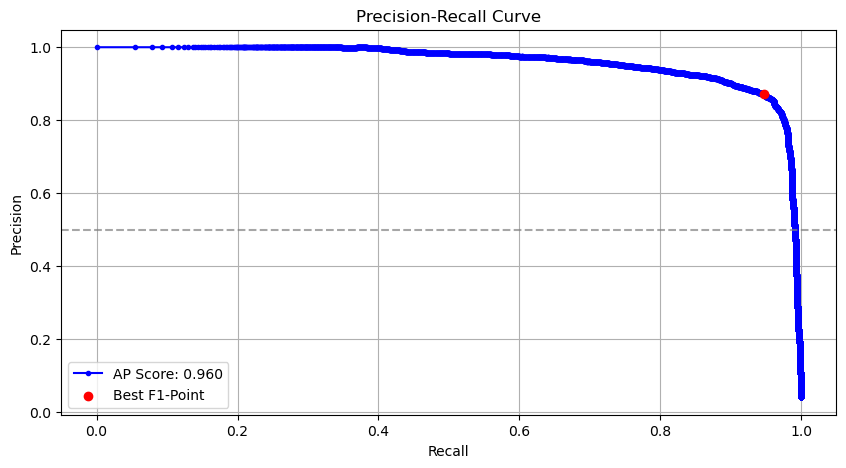

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve

# 🔹 Precision-Recall Curve
plt.figure(figsize=(10, 5))

precisions, recalls, thresholds = precision_recall_curve(y_test_mod, y_test_pred_proba)
f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-10)
best_idx = np.argmax(f1_scores)

plt.plot(recalls, precisions, marker='.', label=f'AP Score: {ap_score:.3f}', color='blue')
plt.axhline(0.5, linestyle='dashed', color='gray', alpha=0.7)  # Garis referensi
plt.scatter(recalls[best_idx], precisions[best_idx], color='red', label='Best F1-Point', zorder=3)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.legend()
plt.grid()
plt.show()

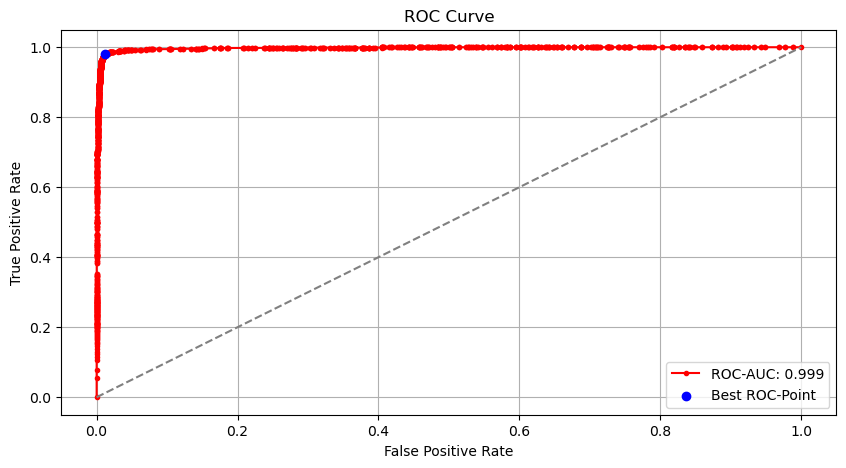

In [73]:
# 🔹 ROC Curve
plt.figure(figsize=(10, 5))

fpr, tpr, thresholds = roc_curve(y_test_mod, y_test_pred_proba)
roc_auc_final = halving_search.best_score_
best_roc_idx = np.argmax(tpr - fpr)  # Titik optimal

plt.plot(fpr, tpr, marker='.', label=f'ROC-AUC: {roc_auc_final:.3f}', color='red')
plt.plot([0, 1], [0, 1], linestyle='dashed', color='gray')  # Garis baseline
plt.scatter(fpr[best_roc_idx], tpr[best_roc_idx], color='blue', label='Best ROC-Point', zorder=3)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.legend()
plt.grid()
plt.show()

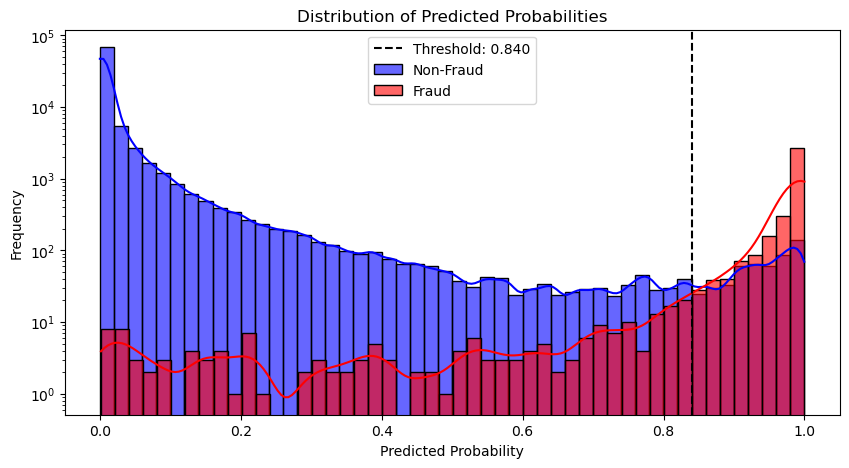

In [74]:
# 🔹 Histogram Probabilitas Prediksi
plt.figure(figsize=(10, 5))

sns.histplot(y_test_pred_proba[y_test_mod == 0], bins=50, label='Non-Fraud', color='blue', alpha=0.6, kde=True)
sns.histplot(y_test_pred_proba[y_test_mod == 1], bins=50, label='Fraud', color='red', alpha=0.6, kde=True)

plt.axvline(best_threshold, color='black', linestyle='dashed', label=f'Threshold: {best_threshold:.3f}')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.yscale('log')  # Skala log jika distribusi sangat tidak seimbang
plt.title('Distribution of Predicted Probabilities')

plt.legend()
plt.show()

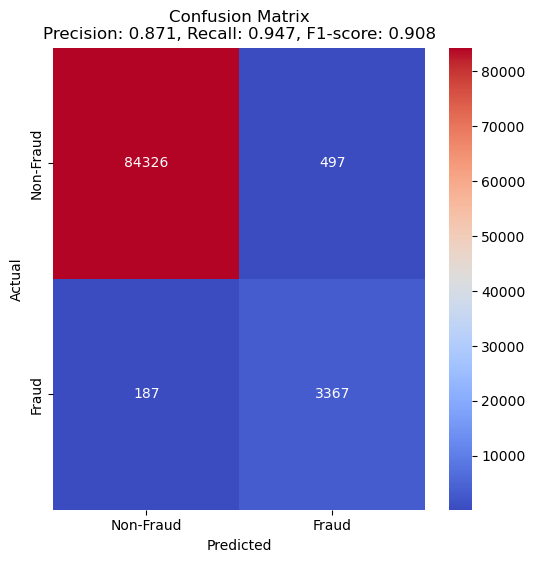

In [75]:
from sklearn.metrics import f1_score, precision_score, recall_score

# 🔹 Confusion Matrix dengan Metrik Evaluasi
cm = confusion_matrix(y_test_mod, y_test_pred)
precision = precision_score(y_test_mod, y_test_pred)
recall = recall_score(y_test_mod, y_test_pred)
f1 = f1_score(y_test_mod, y_test_pred)

plt.figure(figsize=(6, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}')

plt.show()

# Save Model

In [76]:
# Tentukan folder tujuan
dir_name = 'datamart'
folder_path = f"../{dir_name}"

# Cek apakah folder sudah ada, jika belum buat foldernya
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
    print(f"Directory '{dir_name}' created successfully.")

else: 
    print(f'Directory has already been created.')

Directory has already been created.


In [77]:
import joblib

# parameter
share = {**dotenv_values('../.env.shared')} 

# Simpan model terbaik ke file
joblib.dump(final_model, share['FRAUD_DETECT'])

print("Model berhasil disimpan!")

Model berhasil disimpan!
